* 手动实现前馈神经网络

**数据集介绍**

Fashion-MNIST数据集下载

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='~\Datasets\FashionMNIST',train=True,download=True,transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~\Datasets\FashionMNIST',train=False,download=True,transform=transforms.ToTensor())

批量读取数据

In [3]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size = batch_size,shuffle = True,num_workers=0)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=0)

**模型设计**

模型参数定义及初始化

In [4]:
##定义模型参数
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype = torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs,dtype=torch.float)

params = [W1,b1,W2,b2]
for param in params:
    param.requires_grad_(requires_grad=True)

定义激活函数 （ReLU）

In [5]:
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

定义softmax函数

In [6]:
def softmax(X):
    X_exp = X.exp()
    partiton = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partiton

定义交叉熵损失函数

In [7]:
loss = torch.nn.CrossEntropyLoss()

定义模型

In [8]:
def net(X,W1,b1,W2,b2):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return softmax(torch.matmul(H, W2) + b2)

定义随机梯度下降函数

In [9]:
def SGD(params,lr):
    for param in params:
        param.data -= lr * param.grad

计算分类准确率

In [10]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim = 1)==y).float().mean().item()

计算模型在某个数据集上的准确率

In [11]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X,W1,b1,W2,b2).argmax(dim=1)==y).float().sum().item()
        n += y.shape[0]
    return acc_sum/n

定义模型训练函数

In [12]:
def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params = None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X,W1,b1,W2,b2)
            l = loss(y_hat, y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params,lr)
            else:
                optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1)==y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train_acc %.3f, test_acc %.3f'
              %(epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc))

训练模型

In [13]:
num_epochs = 5
lr = 0.1
train(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0309, train_acc 0.544, test_acc 0.707
epoch 2, loss 0.0270, train_acc 0.763, test_acc 0.776
epoch 3, loss 0.0263, train_acc 0.790, test_acc 0.790
epoch 4, loss 0.0261, train_acc 0.799, test_acc 0.798
epoch 5, loss 0.0260, train_acc 0.805, test_acc 0.798


* Torch.nn实现前馈神经网络

实现FlattenLayer层

In [14]:
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)

模型定义和参数初始化

In [15]:
num_inputs, num_output, num_hidens  = 784, 10, 256

net = nn.Sequential(
        FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens, num_outputs),
        )

for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)

计算模型在某个数据集上的准确率和loss

In [16]:
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0 
    test_l_sum = 0.0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1)==y).float().sum().item()
        l = loss(net(X), y).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum / n,test_l_sum/n

设置训练轮次、学习率、损失函数和优化器

In [17]:
num_epochs = 25
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr)

模型训练，保存训练集和验证集的loss

In [18]:
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    train_loss=[]
    test_loss=[]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat,y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params, lr)
            else:
                optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1)==y).sum().item()
            n += y.shape[0]
        test_acc,test_l = evaluate_accuracy(test_iter,net,loss)
        train_loss.append(train_l_sum/n)
        test_loss.append(test_l)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              %(epoch+1, train_l_sum/n, train_acc_sum / n, test_acc))
    return train_loss,test_loss

训练结果和loss曲线绘制

In [19]:
train_loss, test_loss = train(net,train_iter,test_iter,loss,num_epochs,batch_size,net.parameters(),lr,optimizer)

epoch 1, loss 0.0225, train acc 0.555, test acc 0.653
epoch 2, loss 0.0120, train acc 0.720, test acc 0.744
epoch 3, loss 0.0100, train acc 0.778, test acc 0.783
epoch 4, loss 0.0090, train acc 0.805, test acc 0.799
epoch 5, loss 0.0083, train acc 0.820, test acc 0.809
epoch 6, loss 0.0079, train acc 0.828, test acc 0.817
epoch 7, loss 0.0076, train acc 0.833, test acc 0.823
epoch 8, loss 0.0074, train acc 0.837, test acc 0.825
epoch 9, loss 0.0072, train acc 0.840, test acc 0.828
epoch 10, loss 0.0071, train acc 0.844, test acc 0.826
epoch 11, loss 0.0069, train acc 0.847, test acc 0.834
epoch 12, loss 0.0068, train acc 0.849, test acc 0.833
epoch 13, loss 0.0067, train acc 0.851, test acc 0.837
epoch 14, loss 0.0066, train acc 0.854, test acc 0.822
epoch 15, loss 0.0065, train acc 0.855, test acc 0.836
epoch 16, loss 0.0065, train acc 0.857, test acc 0.842
epoch 17, loss 0.0064, train acc 0.858, test acc 0.841
epoch 18, loss 0.0063, train acc 0.861, test acc 0.844
epoch 19, loss 0.00

绘制loss曲线

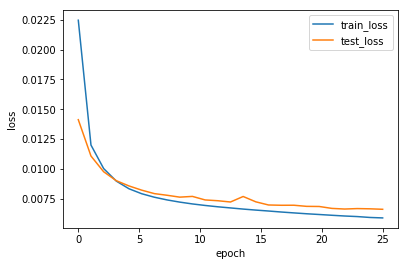

In [22]:
import matplotlib.pyplot as plt

x = np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label='train_loss',linewidth=1.5)
plt.plot(x,test_loss,label='test_loss',linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()